# Imports and parameters

In [1]:
import os
import astropy.units as u
import astropy.constants as const
import numpy as np
import copy
import matplotlib.pyplot as plt

from PerseusGammaCalibration import perseus_model_library
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
outdir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Define the models

In [3]:
cluster = perseus_model_library.default_model()
cluster.Npt_per_decade_integ = 50

In [4]:
Clist = []

#---------- eta = 2, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**2.0}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=2.0$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**1.0}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=1.0$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 0.5, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**0.5}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=0.5$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 0.0, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**0.0}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=0.0$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.5
ctmp = copy.deepcopy(cluster)
ctmp.set_density_crp_isodens_scal_param(1.0)
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.5, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=1$, $\alpha_{\rm CRp}=2.5$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.7
ctmp = copy.deepcopy(cluster)
ctmp.set_density_crp_isodens_scal_param(1.0)
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.7, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=1$, $\alpha_{\rm CRp}=2.7$'
Clist.append(ctmp)

# Energy ratio profile

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/model_modpar.py:1118: RuntimeWarning: divide by zero encountered in log10
  np.log10(user_p), kind='linear', fill_value='extrapolate')
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


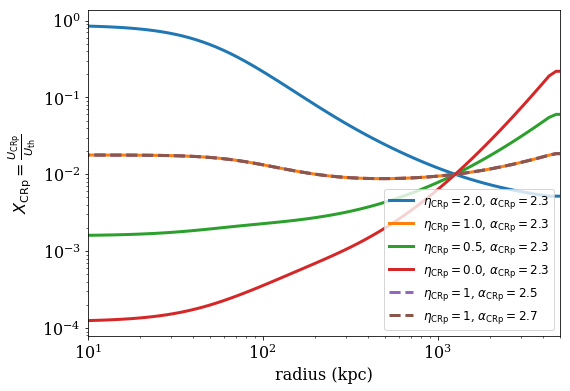

In [5]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2,3]:
    r, x = Clist[i].get_crp_to_thermal_energy_profile()
    plt.loglog(r.to_value('kpc'), x, label=Clist[i].name, linewidth=3)
    
for i in [4,5]:
    r, x = Clist[i].get_crp_to_thermal_energy_profile()
    plt.loglog(r.to_value('kpc'), x, label=Clist[i].name, linestyle='--', linewidth=3)
    
plt.xlabel(r'radius (kpc)')
plt.ylabel(r'$X_{\rm CRp} = \frac{U_{\rm CRp}}{U_{\rm th}}$')
plt.xlim(10,5000)
plt.legend(fontsize=12, loc='lower right')
plt.savefig(outdir+'/CR_Xcrp_models.pdf')

# Gamma ray spectrum

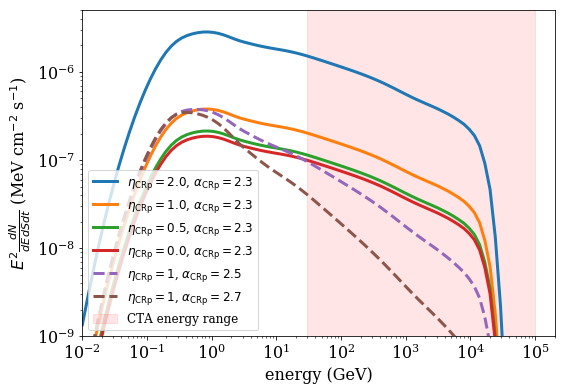

In [6]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2,3]:
    e, s = Clist[i].get_gamma_spectrum(Rmax=Clist[i].R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label=Clist[i].name, linewidth=3)
    
for i in [4,5]:
    e, s = Clist[i].get_gamma_spectrum(Rmax=Clist[i].R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label=Clist[i].name, linestyle='--', linewidth=3)
    
plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='red', alpha=0.1, label='CTA energy range')
plt.xlabel(r'energy (GeV)')
plt.ylabel(r'$E^2\frac{dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-9, 5e-6)
plt.legend(loc='lower left', fontsize=12)
plt.savefig(outdir+'/CR_Gamma_spectrum_models.pdf')

# Gamma ray profile

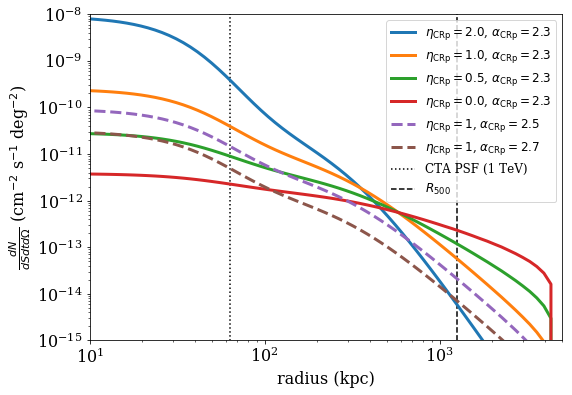

In [7]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2,3]:
    r, p = Clist[i].get_gamma_profile(Emin=50*u.GeV, Emax=100*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label=Clist[i].name, linewidth=3)
    
for i in [4,5]:
    r, p = Clist[i].get_gamma_profile(Emin=50*u.GeV, Emax=100*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label=Clist[i].name, linestyle='--', linewidth=3)
plt.vlines((0.05*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k', label='CTA PSF (1 TeV)')
plt.vlines(cluster.R500.to_value('kpc'), 0,1, linestyle='--', color='k', label='$R_{500}$')
plt.xlabel(r'radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-15,1e-8)
plt.legend(fontsize=12)
plt.savefig(outdir+'/CR_Gamma_profile_models.pdf')